In [1]:
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm

In [2]:
class QuadraticModel(nn.Module):
    def __init__(self, dims=10, scale=None, theta=None):
        super().__init__()
        if theta is not None and scale is not None:
            self.scale = scale
            self.theta = theta
        else:
            self.scale = torch.tensor(np.random.uniform(low=0.5, high=1.5, size=(dims,)).astype(np.float32))
            theta = torch.tensor(np.random.uniform(low=-1, high=1, size=(dims,)).astype(np.float32))
            self.theta = nn.Parameter(theta)
    def forward(self):
        return torch.sum((self.theta * self.scale) ** 2)

In [3]:
class SGD:
    def __init__(self, lr=1e-1):
        self.lr = lr
    def __call__(self, grads):
        return -self.lr * grads
class RMSProp:
    def __init__(self, lr=1e-1, decay=0.99):
        self.lr = lr
        self.decay = decay
        self.state = None
    def __call__(self, grads):
        if self.state is None:
            self.state = torch.zeros_like(grads)
        state = self.state
        state = self.decay * state + (1 - self.decay) * torch.pow(grads, 2)
        self.state = state
        update = -self.lr * grads / (torch.sqrt(state) + 1e-6)
        return update

In [4]:
losses = {'iter': [], 'loss': [], 'optim': []}

In [5]:
for _ in range(10):
    q = QuadraticModel()
    sgd = SGD()
    for i in range(20):
        y = q()
        losses['iter'].append(i)
        losses['loss'].append(float(y.data.numpy()))
        losses['optim'].append('SGD')
        grads = torch.autograd.grad(y, q.theta)[0].detach()
        update = sgd(grads)
        q.theta.data += update
    print(y.item())

0.029571931809186935
0.015939220786094666
0.006976395845413208
0.022141078487038612
0.02378375642001629
0.012796781957149506
0.022395871579647064
0.04821525514125824
0.02109808474779129
0.006614229641854763


In [6]:
for _ in range(10):
    q = QuadraticModel()
    rms = RMSProp()
    for i in range(20):
        y = q()
        losses['iter'].append(i)
        losses['loss'].append(float(y.data.numpy()))
        losses['optim'].append('RMSProp')
        grads = torch.autograd.grad(y, q.theta)[0].detach()
        update = rms(grads)
        q.theta.data += update
    print(y.item())

1.502390610351078e-17
1.0564194918155634e-15
5.82715511382296e-15
1.1797563827817357e-14
9.61184020017384e-15
8.659463459335416e-15
3.608860951775147e-15
5.922989268508259e-15
5.5727064164677684e-15
9.457299038947292e-15


/Users/abdulfatir/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


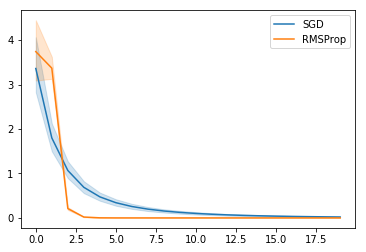

In [7]:
seaborn.lineplot(x='iter', y='loss', hue='optim', data=losses)
plt.show()

In [8]:
class MetaOptimizer(nn.Module):
    def __init__(self, dim=1, hidden=20, out=1, layers=2):
        super().__init__()
        self.hidden = hidden
        self.layers = layers
        self.lstm = nn.LSTM(input_size=dim, hidden_size=hidden, num_layers=layers)
        self.linear = nn.Linear(hidden, out)
    def forward(self, grad, state=None):
        # seq_len x batch x size
        grad = grad.view(1, -1, 1)
        if state is None:
            h = torch.zeros(self.layers, grad.size()[1], self.hidden)
            c = torch.zeros(self.layers, grad.size()[1], self.hidden)
            state = (h, c)
        lstm_out, state = self.lstm(grad, state)
        # lstm_out.shape: seq_len x batch x hidden
        update = self.linear(lstm_out.view(-1, self.hidden))
        return update, state

In [11]:
torch.manual_seed(0)
np.random.seed(0)
meta_optimizer = MetaOptimizer()
meta_optimizer_optim = torch.optim.Adam(meta_optimizer.parameters(), lr = 1e-3)

In [12]:
pbar = range(4000)
state = None
for k in pbar:
    q = QuadraticModel()
    state = None
    loss = 0.
    temp_theta = 0.
    for i in range(20):
        y = q()
        loss += y
        if q.theta.grad is not None:
            q.theta.grad.zero_()
        y.backward(retain_graph=True)
        grads = torch.tensor(q.theta.grad.data) # torch.autograd.grad(y, q.theta, retain_graph=True)[0] # .detach()
        update, state = meta_optimizer(grads, state)
        update = update.view_as(q.theta.data)
        temp_theta = q.theta + update
        temp_theta.retain_grad()
        q = QuadraticModel(scale=q.scale, theta=temp_theta)
    state = (torch.tensor(state[0].data), torch.tensor(state[1].data))
    meta_optimizer_optim.zero_grad()
    loss.backward()
    # print(list(meta_optimizer.parameters())[0].grad)
    nn.utils.clip_grad_norm_(meta_optimizer.parameters(), 1.)
    meta_optimizer_optim.step()
    if (k + 1) % 100 == 0:
        print(loss.item())

7.856927394866943
3.3425545692443848
3.9158518314361572
4.223442554473877
5.856323719024658
4.241034507751465
4.342558860778809
5.855770111083984
3.072840690612793
1.8832263946533203
3.4795022010803223
5.595919609069824
3.362090587615967
3.3252947330474854
1.9921029806137085
5.348099231719971
1.7824023962020874
2.872892379760742
4.610047340393066
3.137704849243164
5.1892619132995605
3.321563243865967
3.7615861892700195
2.436392068862915
1.7292745113372803
2.512012481689453
6.028120994567871
3.350865125656128
1.9898107051849365
2.549522638320923
3.360713481903076
3.8377323150634766
4.892670631408691
4.905352592468262
4.109656810760498
2.7453181743621826
4.523747444152832
8.142844200134277
3.566744089126587
2.8963706493377686


In [13]:
for _ in range(10):
    q = QuadraticModel()
    state = None
    for i in range(20):
        y = q()
        losses['iter'].append(i)
        losses['loss'].append(float(y.data.numpy()))
        losses['optim'].append('LSTM')
        grads = torch.autograd.grad(y, q.theta)[0].detach()
        update, state = meta_optimizer(grads, state)
        update = update.view_as(q.theta.data)
        q.theta.data += update
    print(y.item())

1.6901596609386615e-05
1.2095997590222396e-05
1.2672222510445863e-05
1.2561970834212843e-05
1.1932733286812436e-05
1.147808779933257e-05
9.329865861218423e-06
1.1174297469551675e-05
1.3978168681205716e-05
1.2863374649896286e-05


/Users/abdulfatir/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


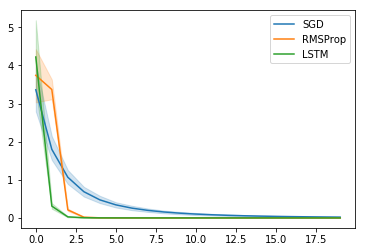

In [14]:
seaborn.lineplot(x='iter', y='loss', hue='optim', data=losses)
plt.show()

In [ ]:
meta_optimizer

In [ ]:
x = torch.tensor([5])

In [ ]:
y = x ** 2

In [ ]:
torch.autograd.grad(y, x)